# Sentiment Analysis with Xgboost

Predict the `score` assigned with each text amazon fine food reviews using xgboost.

### Libraries

In [23]:
import sys
!{sys.executable} -m pip install wordcloud
!{sys.executable} -m pip install xgboost

import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from collections import Counter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # colorful plots
from collections import Counter
import xgboost as xgb
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, roc_auc_score #evaluation
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix
from time import time #check runtime



twisted 18.7.0 requires PyHamcrest>=1.9.0, which is not installed.
You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\dena1\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dena1\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


twisted 18.7.0 requires PyHamcrest>=1.9.0, which is not installed.
You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


### Constants and Configurations

In [24]:
#--------------------------------------------------------------------------------
# Constants and Configurations

DATA_LOCAL = True
LOCAL_PATH = "../data/"
REMOTE_PATH = "https://s3.amazonaws.com/coetichr/AmazonFoodReviews/"
NROWS = 10000 #edit with a smaller size to develop faster
TOKENIZER = RegexpTokenizer(r'\w+') #no punctuation
STEMMER = nltk.PorterStemmer()
STOPWORD_CORPUS = stopwords.words("english")
COLUMNS_TO_DROP = ["ProductId", "UserId", "ProfileName", "Time", "Summary", "HelpfulnessDenominator", "HelpfulnessNumerator"]


### Load Data

In [25]:
'''
Load the data from the csv file
@param file Filename to load
@param nrow_value Number of rows to load
@reutrn dataframe
'''
def load_data(file, nrow_value=NROWS):
    path = LOCAL_PATH if DATA_LOCAL else REMOTE_PATH
    return pd.read_csv(path + file, nrows=nrow_value)

'''
Sets up the dataframe with the correct configs and positivity scores
@param nrows Number of rows if not default NROWS constant
@return dataframe
'''
def setup_df(nrows):
        # Load Reviews.csv
    reviewsdf = load_data("Reviews.csv", nrows)

    #drop columns not needed
    reviewsdf.drop(columns=COLUMNS_TO_DROP, inplace=True, axis=1)
    reviewsdf.dropna(inplace=True) #drop empty fields
    reviewsdf['Positivity'] = np.where(reviewsdf['Score'] > 3, 1, 0)

    print("Original DF Shape: ", reviewsdf.shape)
    print(reviewsdf.head())
    return reviewsdf


In [26]:
#test
reviewsdf = setup_df(NROWS)

Original DF Shape:  (10000, 4)
   Id  Score                                               Text  Positivity
0   1      5  I have bought several of the Vitality canned d...           1
1   2      1  Product arrived labeled as Jumbo Salted Peanut...           0
2   3      4  This is a confection that has been around a fe...           1
3   4      2  If you are looking for the secret ingredient i...           0
4   5      5  Great taffy at a great price.  There was a wid...           1


### Analysis

Look at the distribution of different scores and words received for each text review.

In [27]:
'''
Class to quickly generate a plot with the correct settings for this data
'''
class QuickPlot:
    
    '''
    constructor
    @param title Title of the plot to display
    @param sns_style Color of background for seaborn plots
    '''
    def __init__(self, title=""):
        sns.set(style="whitegrid", context="paper")
        plt.subplots(figsize=(10,5))
        self.title = title;
        
    '''
    Generates a wordcloud from frequencies
    @param hash Dictionary mapping the word string to the number/size
    '''
    def wordcloud(self, hash):
        wordcloud = WordCloud(
            width=1400,
            height=600,
            background_color="white",
            colormap="Dark2",
            max_words=50,
            mode="RGBA").generate_from_frequencies(hash)
        
        # plot words
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.show()
        
    '''
    Creates a bar plot with a dataframe
    @param df Dataframe to use
    @param xcol Column for x axis
    @param ycol Column for y axis
    '''
    def barplot(self, df, xcol="count", ycol="token"):
        sns.barplot(x = df[xcol], y = df[ycol], palette="deep").set_title(self.title)
        plt.show() 
        
    '''
    Createa a count plot, where seaborn aggregates the data
    @param df dataframe
    @param xcol X axis to show counts for
    '''
    def countplot(self, df, xcol):
        sns.countplot(x=xcol, data=df, palette="deep").set_title(self.title)
        plt.show()
        
    '''
    Creates a line plot 
    @param df dataframe
    @param xcol X axis to select from dataframe
    @param ycol Y axis to select from dataframe
    '''
    def lineplot(self, df, xcol, ycol):
        sns.lineplot(x=xcol, y=ycol, hue="GnBu_d", data=df).set_title(self.title)
        plt.show()
        

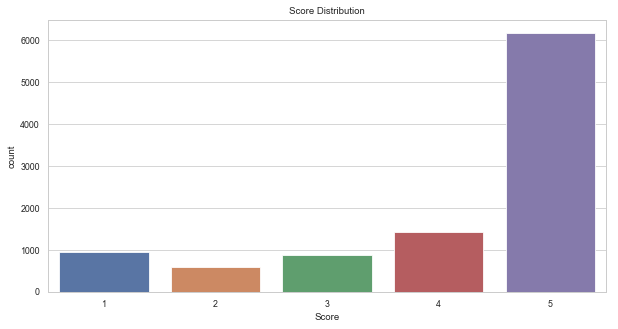

In [28]:
#view distribution of scores

QuickPlot("Score Distribution").countplot(reviewsdf, "Score")

#view top words for each score
#sum_words = bow.sum(axis=0) 
#words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
#words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)

#word_freq_dict = {}
#for a, b in words_freq: 
#    word_freq_dict[a] = float(b)
#QuickPlot().wordcloud(word_freq_dict)

#words_freq_df = pd.DataFrame(word_freq_dict.items(),index=word_freq_dict.keys(), columns=["token", "count"])
#QuickPlot("Top 25 words in reviews").barplot(words_freq_df)

### Data Preprocessing

Going to tokenize the words and anything that might need to be removed (stopwords, puncutation, etc), apply stemming where the root of the word is extracted from the sentence, and create a bag of words model. BoW representation specifies the occurrence of tokens in the whole corpus.

In [29]:
'''
parse the text into tokens and apply to the table, along with stemming
@param row dataframe row to apply
@return array of tokens
'''
def tokenizefn(row):
    rownew = TOKENIZER.tokenize(row) #tokenize    
    #stem
    #rownew = list(map(lambda str: STEMMER.stem(str), rownew))
    return rownew

'''
setup the vectorizer with the params
@param train Training data to fit the vectorizer on
@param ngramrange Max range for ngram size
@param mindf_value Minimum value to allow for the vectorizer
@param is_lowercase boolean to make everything lower case or not
@return Countvectorizer
'''
def vectorizer_setup(train, ngramrange, mindf_value, is_lowercase):    
    #build BoW with different nfram ranges
    vectorizer = CountVectorizer(
        ngram_range = (1, ngramrange),
        analyzer = 'word',
        tokenizer=tokenizefn,
        lowercase=is_lowercase,
        min_df=mindf_value
        ).fit(train)

    print("Number of features: " + str(len(vectorizer.get_feature_names())))
    return vectorizer


In [30]:
X_train, X_test, Y_train, Y_test = train_test_split(reviewsdf["Text"], reviewsdf['Positivity'], random_state = 0)
vectorizer = vectorizer_setup(X_train, 6, 10, False)
print("Training Set: ", X_train.shape)
print("Test Set: ", X_test.shape)

Number of features: 14788
Training Set:  (7500,)
Test Set:  (2500,)


### Model Training & Evaluation

In [31]:
'''
test and train a model with the given params
@param x_train
@param x_test
@param y_train
@param y_test
@param vectorizer CountVecctorizer
'''
class ModelRun():
    def __init__(self, x_train, x_test, y_train, y_test, vectorizer):
        self.xtrain = x_train
        self.xtest = x_test
        self.ytrain = y_train
        self.ytest = y_test
        self.vec = vectorizer
        
    '''
    private function
    Test the accuracy, precision, and recall of a given classifier
    @param classfiier Classifier to run
    '''
    def __test_classifier(self, classifier):
        print("")
        print("===============================================")
        classifier_name = str(type(classifier).__name__)
        print("Testing " + classifier_name)
        now = time()
        list_of_labels = sorted(list(set(self.ytrain)))
        model = classifier.fit(self.vec.transform(self.xtrain), self.ytrain)
        print("Learing time {0}s".format(time() - now))
        now = time()
        predictions = model.predict(self.vec.transform(self.xtest))
        print("Predicting time {0}s".format(time() - now))

        precision = precision_score(self.ytest, predictions, average=None, pos_label=None, labels=list_of_labels)
        recall = recall_score(self.ytest, predictions, average=None, pos_label=None, labels=list_of_labels)
        accuracy = accuracy_score(self.ytest, predictions)
        f1 = f1_score(self.ytest, predictions, average=None, pos_label=None, labels=list_of_labels)
        auc = roc_auc_score(self.ytest, predictions)
        print("=================== Results ===================")
        print("            Negative     Neutral     Positive")
        print("F1       " + str(f1))
        print("Precision" + str(precision))
        print("Recall   " + str(recall))
        print("Accuracy " + str(accuracy))
        print("AUC " + str(auc))
        print("===============================================")

        return precision, recall, accuracy, f1, auc

    '''
    LogisticRegressioni model
    @param multiclass_val
    @param solver_val
    @return precision, recall, accuracy, f1, auc
    '''
    def logistic_regression_run(self, multiclass_val='ovr', solver_val='liblinear'):
        return self.__test_classifier(
            LogisticRegression(
                random_state=0,
                solver=solver_val,
                multi_class=multiclass_val,
                n_jobs=-1))

    '''
    XGBClassifier model
    @param max_depth_val
    @param n_estimators_val
    @return precision, recall, accuracy, f1, auc
    '''
    def xgb_classifier_run(self, max_depth_val=50, n_estimators_val=1000):
        return self.__test_classifier(
        xgb.XGBClassifier(
            silent=True,
            max_depth=max_depth_val,
            n_jobs=4,
            n_estimators=n_estimators_val
        ))


In [32]:
ModelRun(X_train, X_test, Y_train, Y_test, vectorizer).logistic_regression_run()


Testing LogisticRegression


C:\Users\dena1\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1232: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


Learing time 6.959363698959351s
Predicting time 1.7440104484558105s
=================== Results ===================
            Negative     Neutral     Positive
F1       [0.70017953 0.91405044]
Precision[0.78313253 0.88711289]
Recall   [0.63311688 0.94267516]
Accuracy 0.8664
AUC 0.787896021176276


(array([0.78313253, 0.88711289]),
 array([0.63311688, 0.94267516]),
 0.8664,
 array([0.70017953, 0.91405044]),
 0.787896021176276)